# Libraries

In [10]:
import joblib

import pandas 			 as pd
import numpy 			 as np
import matplotlib.pyplot as plt

import scipy.signal 	 as signal
import scipy.stats 		 as stats

from sklearn.metrics import root_mean_squared_error

# ECG Definitions

ECG file headers

In [11]:
ecgHeaders = [
	"sample",
	"LI", 
	"LII", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V2",
	"V3",
	"V4",
	"V5",
	"V6"
]

Loading ECGs labeled as acceptable

In [12]:
ecgsDataset = []

with open("../../../data/labels/RECORDS-acceptable") as file:
	ecgsDataset = map(
		lambda ecgName: ecgName.strip(), 
		file.readlines()
	)
	ecgsDataset = list(ecgsDataset) 

	print("Dataset len =", len(ecgsDataset))

Dataset len = 773


ECG preprocessing function

- highpass butterworth filter with $ f_c = 1$ Hz
- Truncation in the tails of $N = 500$ samples

In [13]:
order = 2
fc = 1
fs = 500

b, a = signal.butter(
	N = order,
	Wn = fc,
	btype = "highpass",
	fs = fs
)

print("Numerator: ",   b)
print("Denominator: ", a)

Numerator:  [ 0.9911536  -1.98230719  0.9911536 ]
Denominator:  [ 1.         -1.98222893  0.98238545]


In [14]:
def preprocessing(ecgDf):
	ecgClean      = ecgDf.apply(
		lambda column: signal.filtfilt(b, a, column), 
		axis = 0
	)
	ecgClean      = ecgClean.iloc[500: -500]
	ecgClean["Z"] = -0.5 * ecgClean["V2"]

	return ecgClean

# Linear Regression Definitions

Features Vector

In [15]:
ecgFeatures = [
	"LII", 
	"Z"  , # Z = -0,5 * V2 
	"V6" , 
]

Target Vector

In [16]:
ecgTarget = [
	"LI", 
	"LIII", 
	"aVR", 
	"aVL",
	"aVF", 
	"V1",
	"V3",
	"V4",
	"V5",
]

Loading Linear Regression Model and Scaler

In [18]:
linearRegression = joblib.load("../../../models/t1/reglin-t1-v0.pkl")

print(linearRegression.coef_)
print(linearRegression.intercept_)

[[  54.70244453   18.31527209   11.96795602]
 [  84.46972928  -18.31527209  -11.96795602]
 [ -96.43291001   -9.17086456   -5.9689189 ]
 [ 111.53151552   -9.16704336   -6.02804296]
 [ -15.42581294   18.3575134    11.97764536]
 [ -60.11021969  -99.1283622   -12.59657385]
 [  67.64952898 -123.68416484   -4.67132156]
 [ 125.74791541  -63.6317882    20.38044535]
 [ 123.76691912  -15.23053019   34.81616359]]
[ 6.11632711e-02 -1.22625340e-01 -4.23057373e-04 -9.17665257e-02
  9.30274688e-02 -1.96289070e-01  7.41486057e-01 -1.87739239e-01
  1.52133815e-01]


In [20]:
scaler = joblib.load("../../../models/t1/reglin-t1-v0.scaler.pkl")

print(scaler.mean_)
print(scaler.var_)

[-0.06146207  0.38280709  0.6721729 ]
[ 19368.89396467  38977.23087252 138327.38372337]


# Graphical analysis of reconstruction performance

Calculating Pearson Correlations and Root Mean Square Error for each ECG

In [21]:
correlations = pd.DataFrame(columns = ecgTarget)
rmseScores 	 = pd.DataFrame(columns = ecgTarget)

for ecgID in ecgsDataset:
	
	# Load and clean ECG file

	ecg      = pd.read_csv(
		filepath_or_buffer = f"../../../data/set-a/{ecgID}.txt",
		names              = ecgHeaders,
		index_col 		   = 0
	)

	ecgClean = preprocessing(ecg)


	# Extract features and expected vector

	features   = ecgClean[ecgFeatures].values
	expected   = ecgClean[ecgTarget]

	
	# Reconstructing the derivations
	
	predicted  = linearRegression.predict(
		X = scaler.transform(
			X = features
		)
	)
	predicted  = pd.DataFrame(
		data    = predicted,
		columns = ecgTarget,
	)


	# Calculating MSE and CORR for each lead

	rmseRow  = pd.DataFrame(columns = ecgTarget)
	corrRow  = pd.DataFrame(columns = ecgTarget)

	for derivation in ecgTarget:
		
		rmseRow[derivation]  = [root_mean_squared_error(
			y_true = expected[derivation],
			y_pred = predicted[derivation]
		)]

		corrRow[derivation] = [stats.pearsonr(
			x = expected[derivation],
			y = predicted[derivation]
		).statistic]


	# Storing the metrics

	rmseScores 	 = pd.concat(
		[rmseScores, rmseRow], 
		ignore_index = True
	)
	correlations = pd.concat(
		[correlations, corrRow],  
		ignore_index = True
	)


/tmp/ipykernel_20561/3690677917.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmseScores 	 = pd.concat(
/tmp/ipykernel_20561/3690677917.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  correlations = pd.concat(
/tmp/ipykernel_20561/3690677917.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corrRow[derivation] = [stats.pearsonr(
/tmp/ipykernel_20561/3690677917.py:48: ConstantInputWarning: An input array is constant; the correlation

Description of statistical measures

In [22]:
correlations = correlations.dropna()
print(correlations.describe())

               LI        LIII         aVR         aVL         aVF          V1  \
count  771.000000  771.000000  771.000000  771.000000  771.000000  771.000000   
mean     0.595167    0.349885    0.870564    0.803386    0.021961    0.724210   
std      0.423162    0.474094    0.179045    0.228261    0.535504    0.337342   
min     -0.939659   -0.852059   -0.245254   -0.311862   -0.948399   -0.811737   
25%      0.464997   -0.021851    0.848696    0.738868   -0.442856    0.648082   
50%      0.772242    0.438421    0.943613    0.891639    0.012500    0.870079   
75%      0.884081    0.775106    0.973917    0.961108    0.476770    0.943931   
max      0.984401    0.997217    0.996751    0.999248    0.985387    0.994051   

               V3          V4          V5  
count  771.000000  771.000000  771.000000  
mean     0.760193    0.735461    0.784424  
std      0.285340    0.292412    0.271919  
min     -0.639401   -0.853397   -0.818682  
25%      0.720265    0.672072    0.752951  
50%   

In [23]:
mseScores = rmseScores.dropna()
print(mseScores.describe())

               LI        LIII         aVR         aVL         aVF  \
count  773.000000  773.000000  773.000000  773.000000  773.000000   
mean    21.961893   21.961893   10.928492   11.079143   21.948815   
std     14.664646   14.664646    7.317144    7.343005   14.659445   
min      4.362662    4.362662    2.148580    2.267200    4.327278   
25%     13.199225   13.199225    6.573667    6.683710   13.171240   
50%     18.523714   18.523714    9.205229    9.359984   18.511593   
75%     26.661006   26.661006   13.287700   13.417338   26.663150   
max    150.232098  150.232098   75.097092   75.155833  150.230278   

                V1           V3           V4           V5  
count   773.000000   773.000000   773.000000   773.000000  
mean     33.679078    39.658104    36.282327    28.074823  
std     179.109822   141.552414   138.854938    71.251464  
min       3.251755     5.242489     5.089611     3.949339  
25%      10.501757    17.544094    14.642930    11.532917  
50%      16.317777

The comparative plot function

In [24]:
def methodComparativePlot(df, derivation, method):
	dfMean = np.mean(df[derivation])
	dfMean = np.round(dfMean, 3)

	figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 6))

	axes[0].set_title(f"{method}($ {derivation} $, $ {derivation}_{{rec}} $)")
	axes[1].set_title(f"Histograma - {method}($ {derivation} $, $ {derivation}_{{rec}} $)")

	axes[0].set_xlabel("n")
	axes[0].set_ylabel(f"{method}")
	
	axes[1].set_xlabel(f"{method}")
	axes[1].set_ylabel("Frequência")


	axes[0].scatter(
		df.index, 
		df[derivation]
	)
	axes[0].axhline(
		dfMean, 
		color     = 'r', 
		linestyle = '--', 
		label     = f"Média = {dfMean}"
	)


	counts, bins = np.histogram(df[derivation], 50)
	axes[1].stairs(counts / len(df[derivation]), bins, fill = True)
	axes[1].axvline(
		dfMean, 
		color     = 'r', 
		linestyle = '--', 
		label     = f"Média = {dfMean}"
	)

	axes[1].legend()
	axes[0].legend()

	plt.show()

	plt.close()

## Results

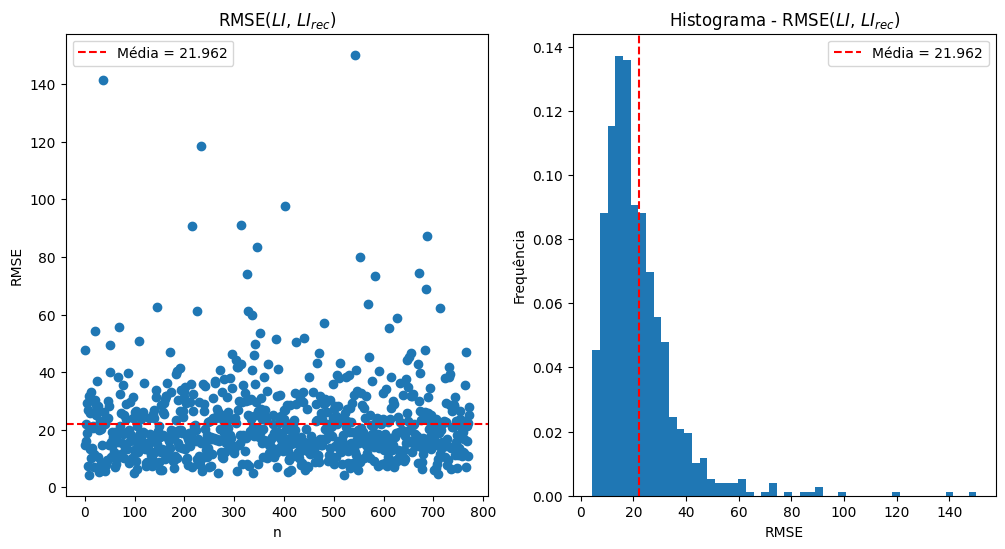

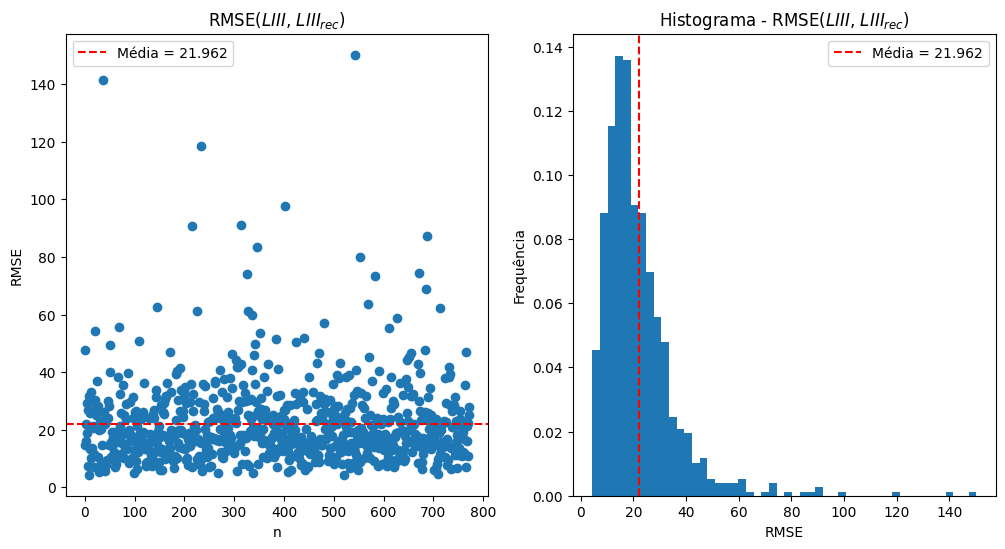

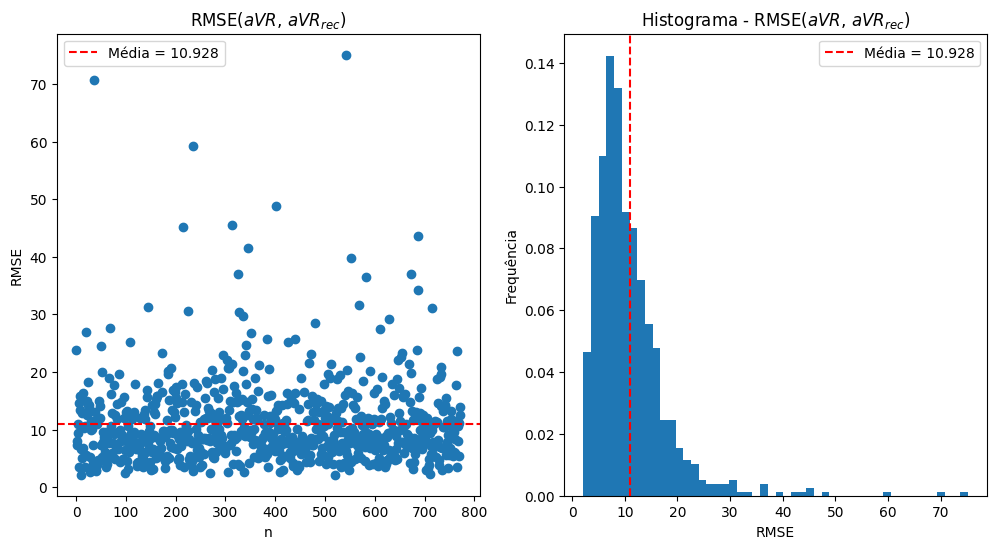

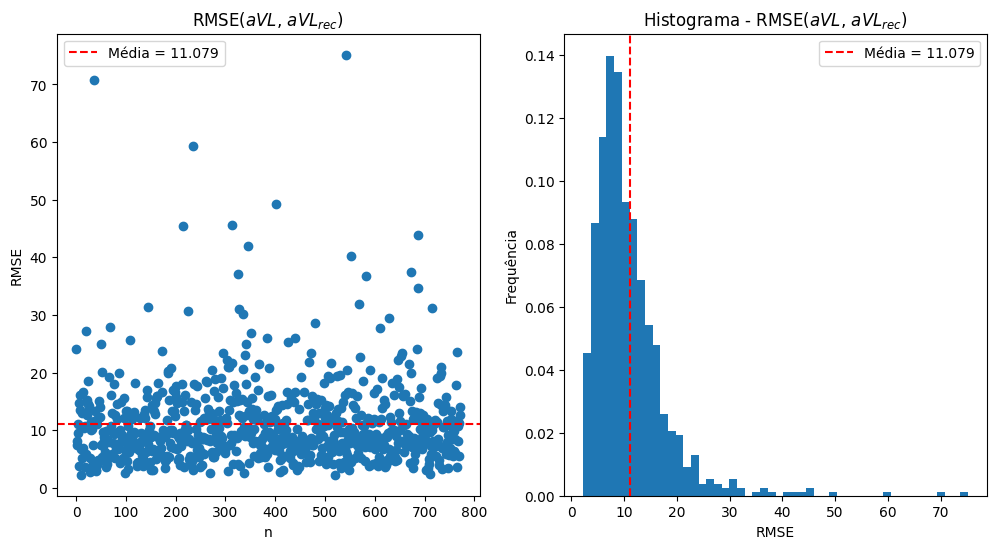

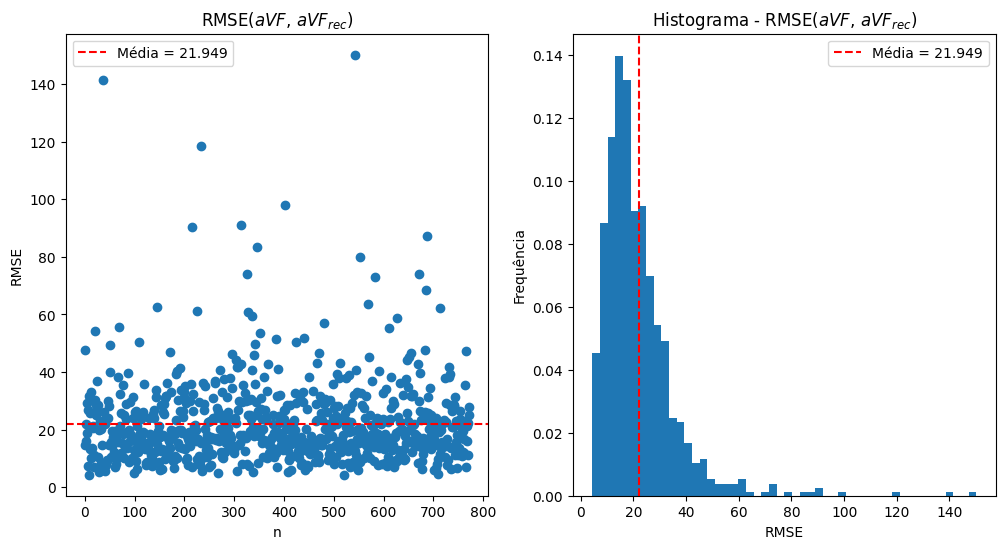

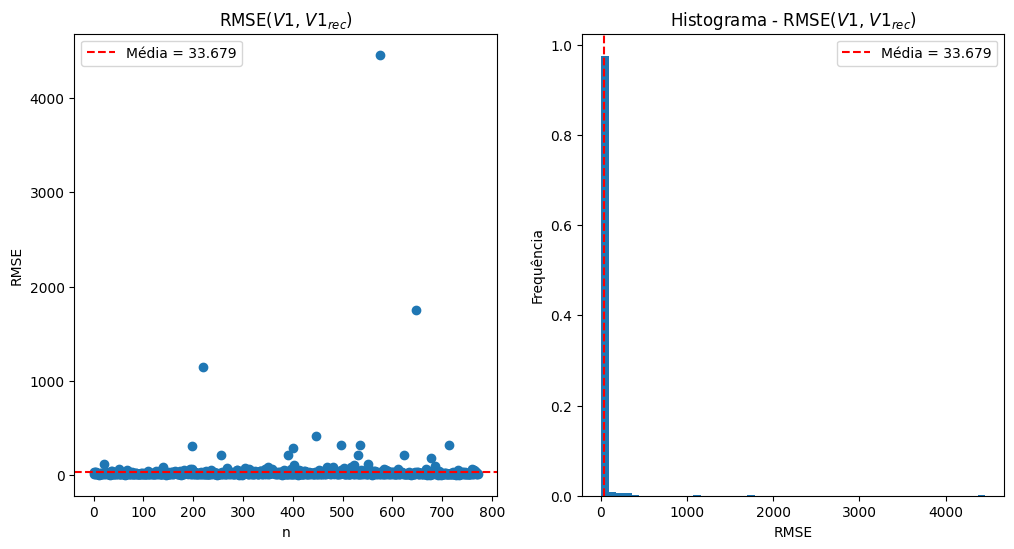

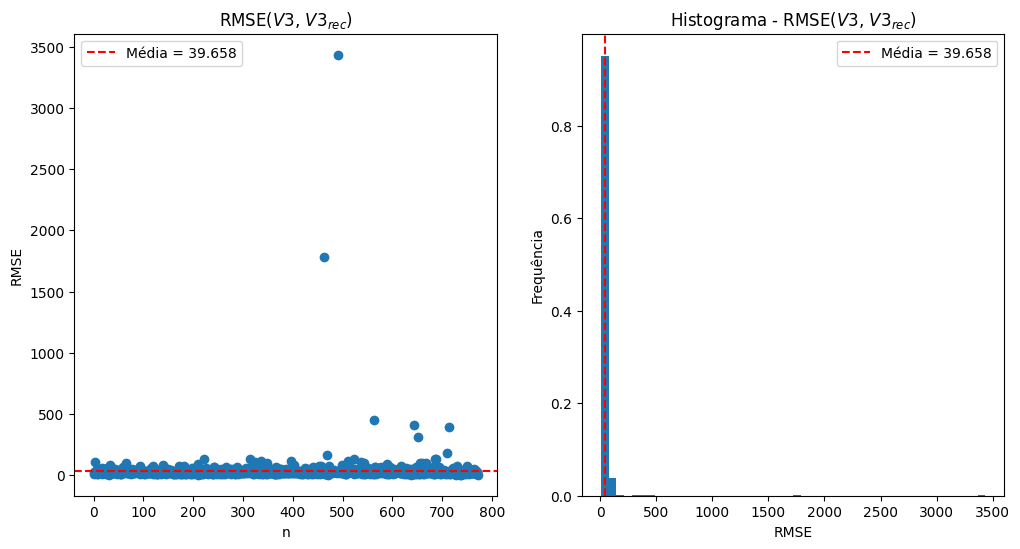

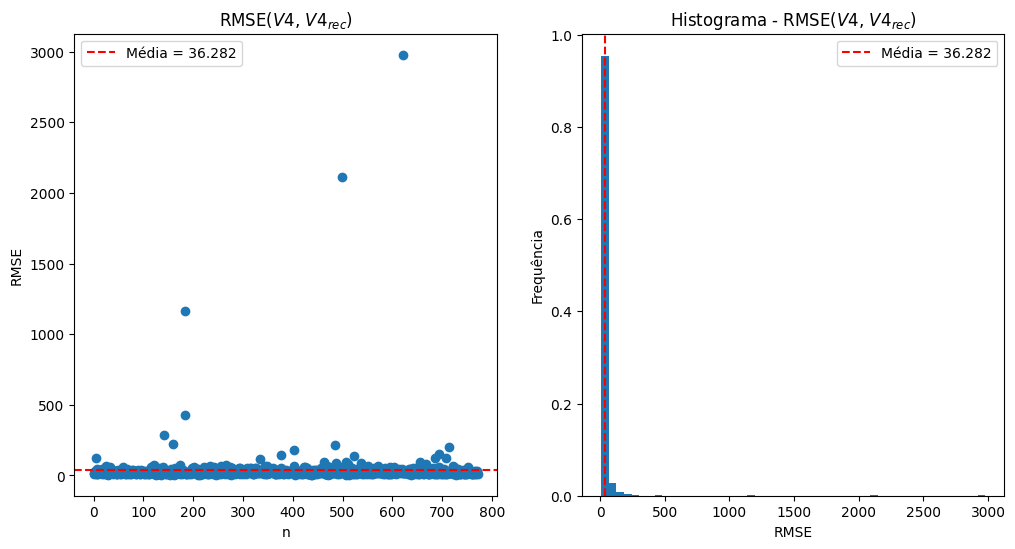

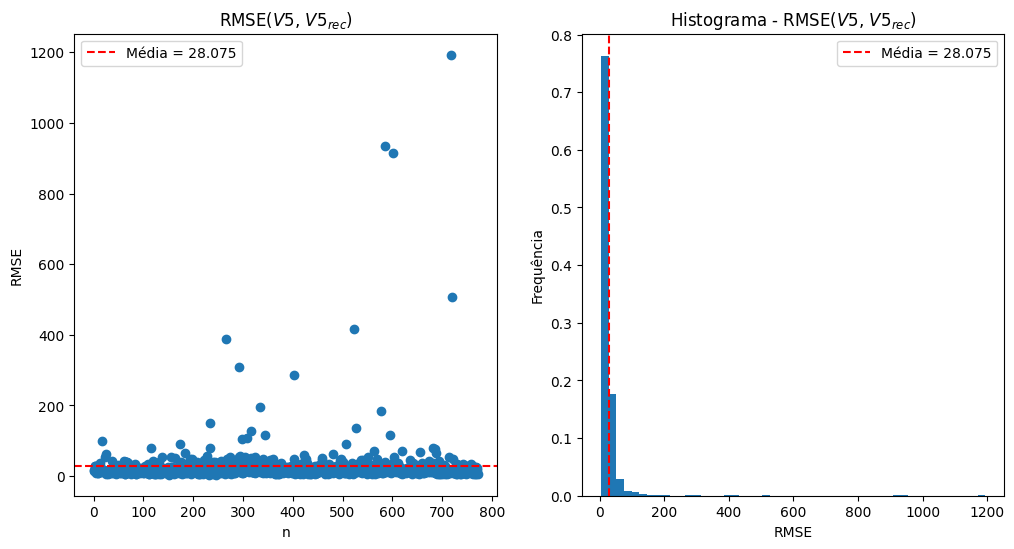

In [25]:
for derivation in ecgTarget:
	methodComparativePlot(mseScores, derivation, "RMSE")

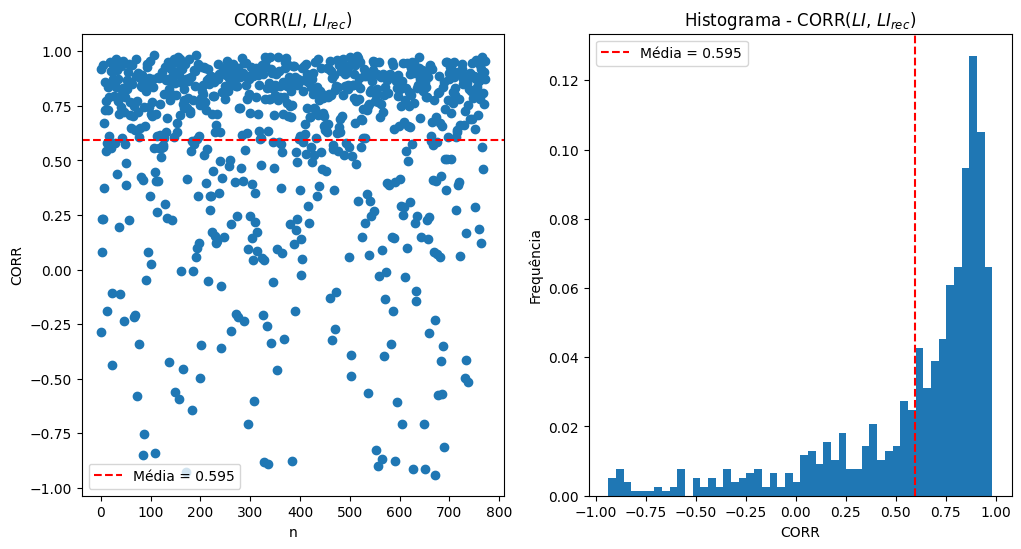

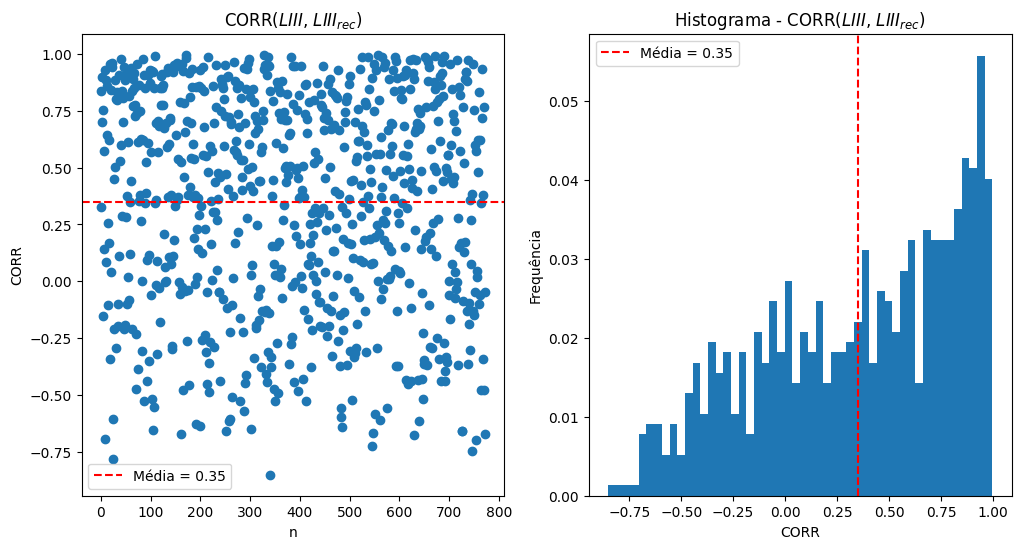

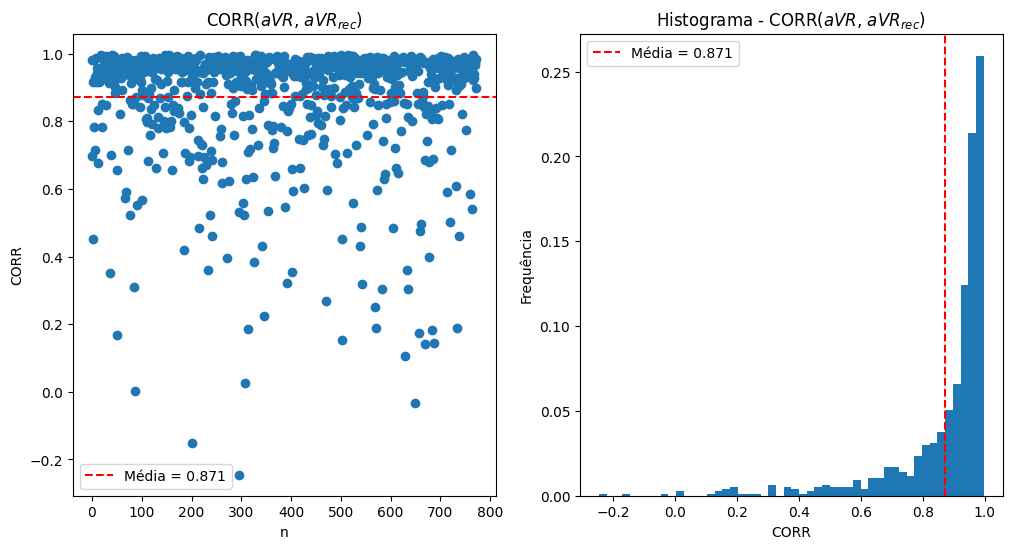

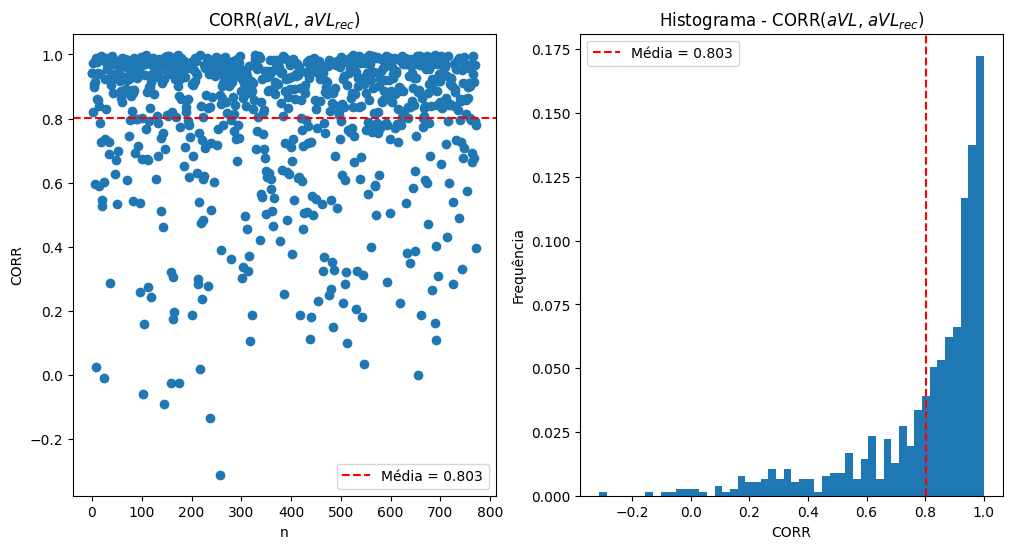

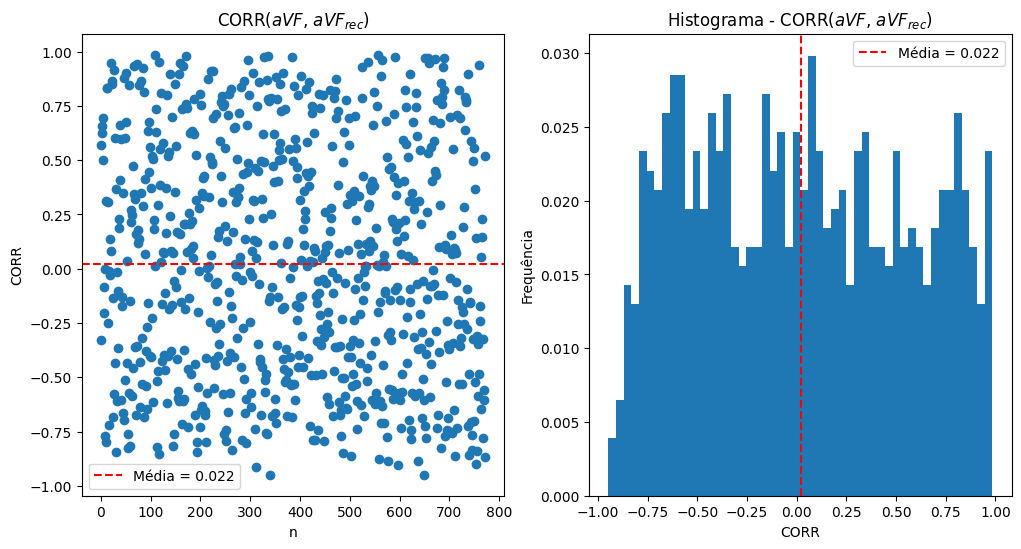

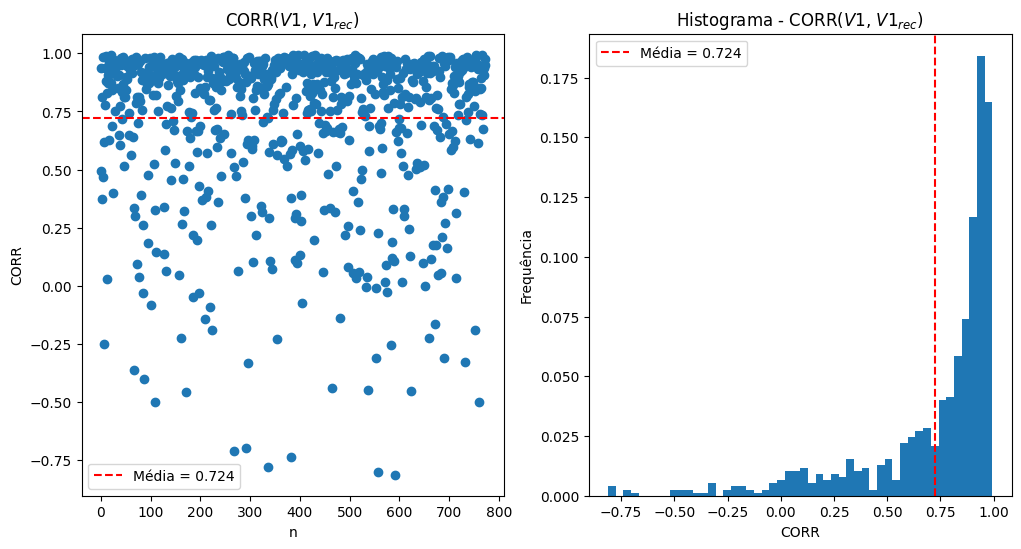

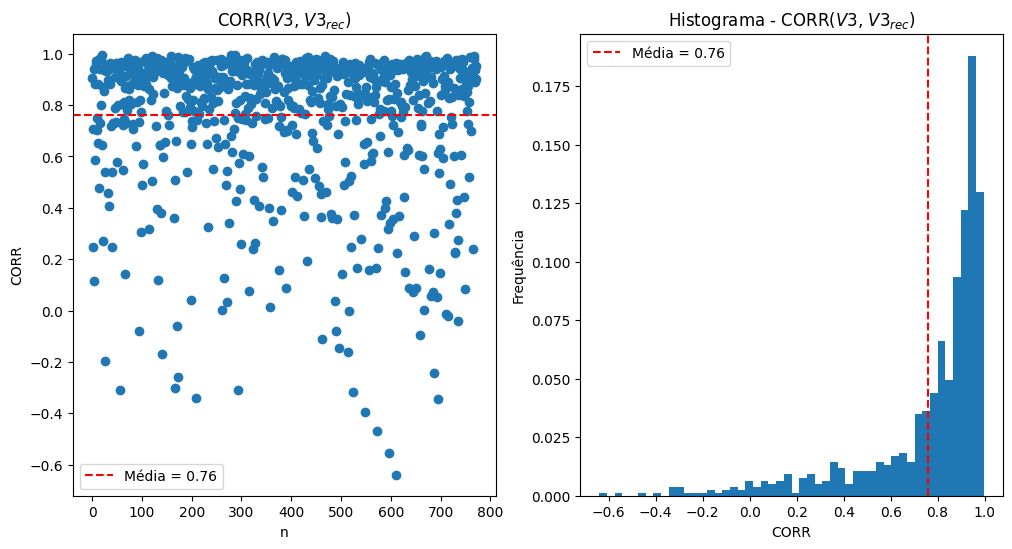

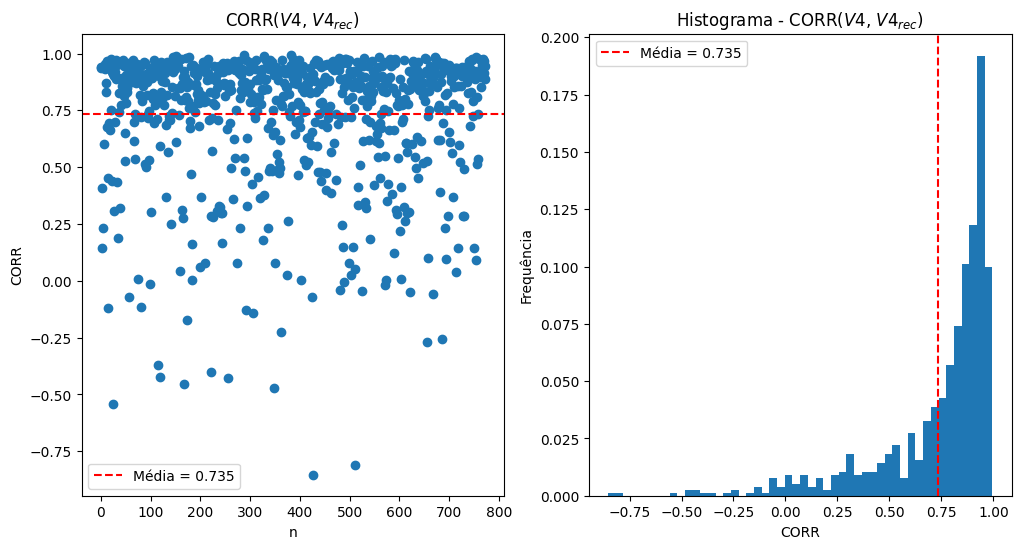

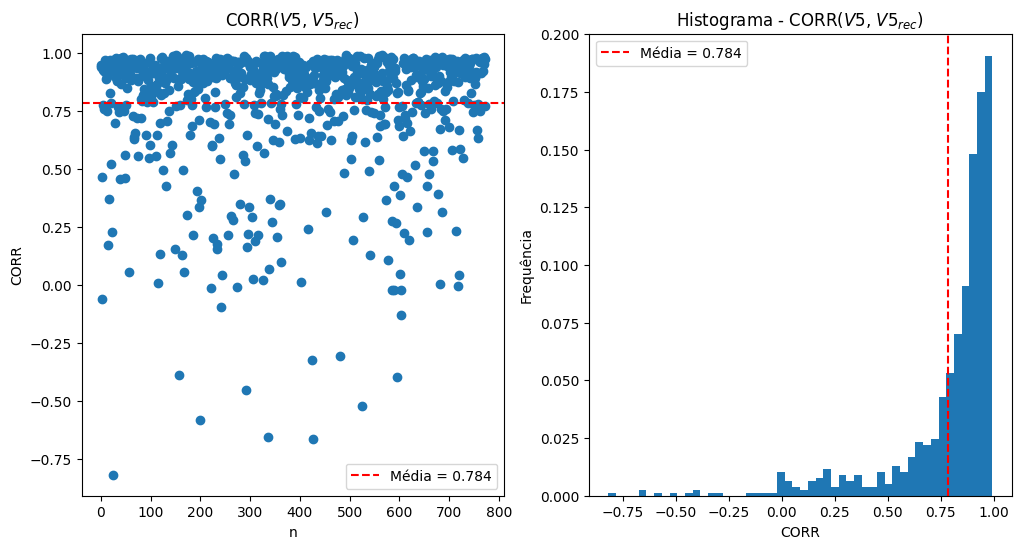

In [26]:
for derivation in ecgTarget:
	methodComparativePlot(correlations, derivation, "CORR")